In [1]:
!pip install yfinance
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.2 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import datetime
import tensorflow as tf
import xgboost as xgb
import warnings


from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, cross_validate

from numpy import mean, std, sqrt
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima import auto_arima
from datetime import datetime

time_start = datetime.now()

In [3]:
## Setting up the start and end date
start_date = '2003-01-01'
end_date = '2023-11-04'

## Data Preprocessing

In [5]:
# Extract market data for currency symbol
currency = 'USDINR'
data = yf.download(currency+'=X', start=start_date, end=end_date)

data = data.reset_index()

[*********************100%%**********************]  1 of 1 completed


In [6]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5168.000000,5168.000000,5168.000000,5168.000000,5168.000000,5168.0
mean,58.677868,58.882106,58.496095,58.679245,58.679245,0.0
std,13.027332,13.056265,12.983559,13.038528,13.038528,0.0
min,38.995998,39.235001,38.979000,39.044998,39.044998,0.0
25%,45.586751,45.731751,45.497751,45.587751,45.587751,0.0
50%,60.440500,60.683001,60.150002,60.444000,60.444000,0.0
75%,69.578003,69.772497,69.335850,69.667673,69.667673,0.0
max,85.194000,84.929298,83.224998,85.194000,85.194000,0.0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5168 entries, 0 to 5167
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5168 non-null   datetime64[ns]
 1   Open       5168 non-null   float64       
 2   High       5168 non-null   float64       
 3   Low        5168 non-null   float64       
 4   Close      5168 non-null   float64       
 5   Adj Close  5168 non-null   float64       
 6   Volume     5168 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 282.8 KB


## Data Visualization

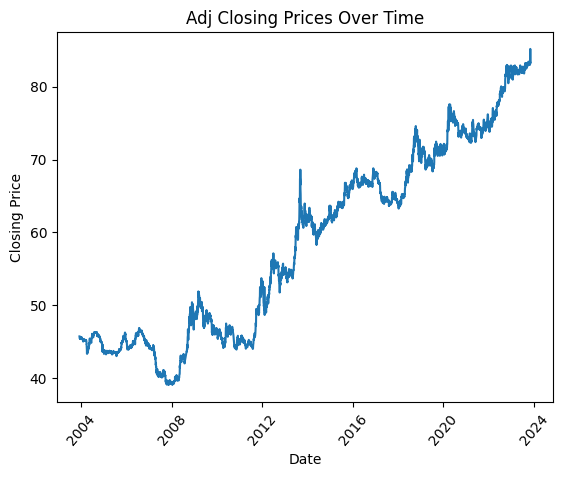

In [12]:
# Plot the Adj closing prices
plt.plot(data['Date'] ,data['Adj Close'])
plt.title("Adj Closing Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price")

plt.xticks(rotation=50)
plt.savefig('USDINR adj closing price')

plt.show()

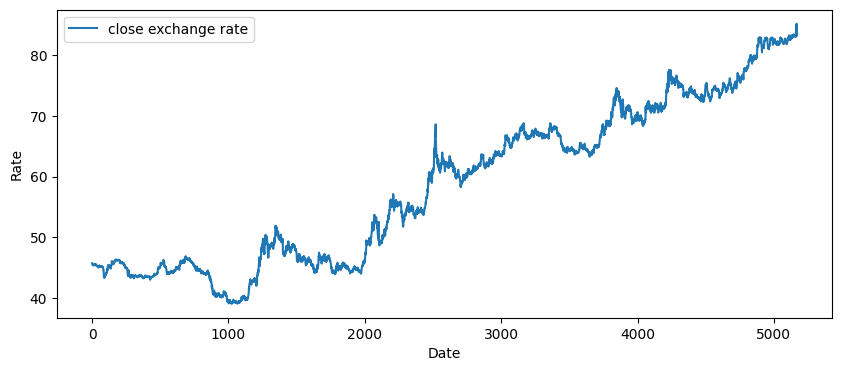

In [13]:
plt.figure(figsize=(10, 4))

plt.xlabel('Date')
plt.ylabel('Rate')

plt.plot(data['Adj Close'], label='close exchange rate')
plt.legend()
plt.savefig('USD-INR exchange rate')
plt.show()

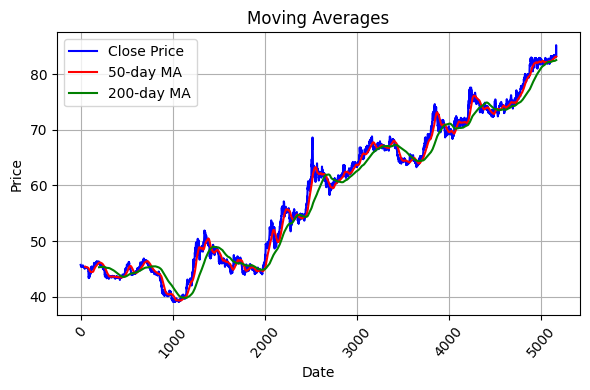

In [14]:
plt.figure(figsize=(6,4))

plt.plot(data.index, data["Adj Close"], label="Close Price", color='b')
plt.plot(data.index, data["Adj Close"].rolling(window=50).mean(), label="50-day MA", color='r')
plt.plot(data.index, data["Adj Close"].rolling(window=200).mean(), label="200-day MA", color='g')

plt.title("Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")

plt.grid(True)
plt.legend()
plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

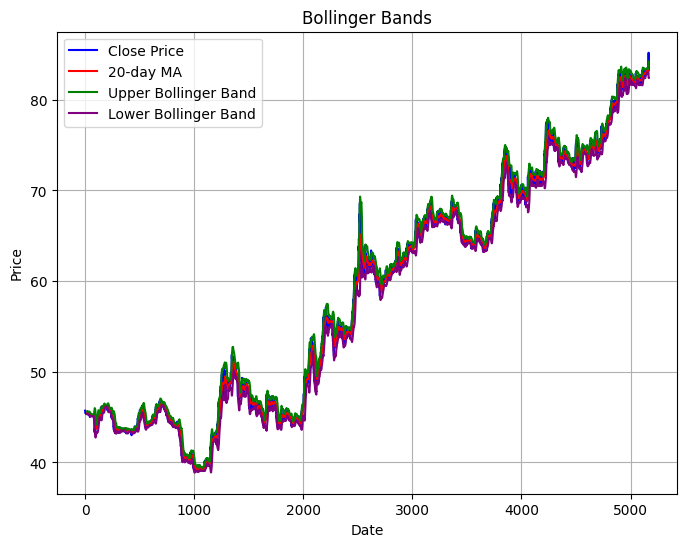

In [15]:
data['20MA'] = data['Adj Close'].rolling(window=20).mean()
data['Upper'] = data['20MA'] + 2 * data['Adj Close'].rolling(window=20).std()
data['Lower'] = data['20MA'] - 2 * data['Adj Close'].rolling(window=20).std()

plt.figure(figsize=(8, 6))

plt.plot(data.index, data['Adj Close'], label='Close Price', color='blue')
plt.plot(data.index, data['20MA'], label='20-day MA', color='red')
plt.plot(data.index, data['Upper'], label='Upper Bollinger Band', color='green')
plt.plot(data.index, data['Lower'], label='Lower Bollinger Band', color='purple')

plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()

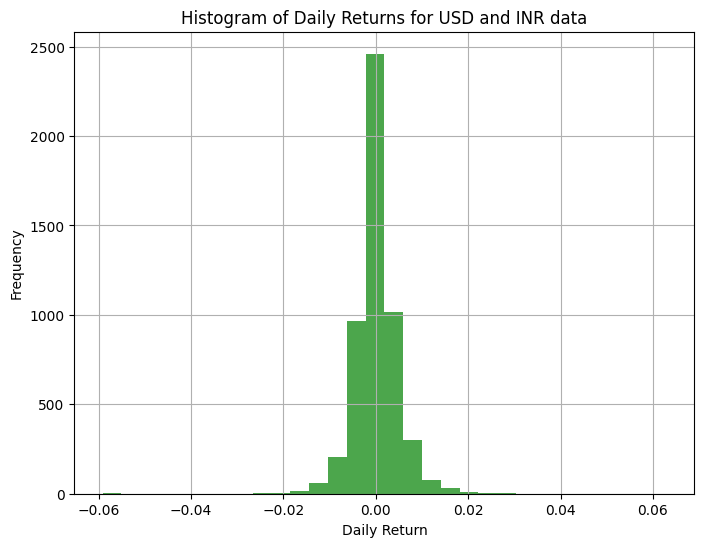

In [16]:
data['Daily Return'] = data['Adj Close'].pct_change()

plt.figure(figsize=(8, 6))

plt.hist(data['Daily Return'].dropna(), bins=30, color='green', alpha=0.7)
plt.title('Histogram of Daily Returns for USD and INR data')

plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)

## Splitting of data

In [17]:
# Defining dataset for training, test and validation
feature_data_set = data

train_data_size = int(len(feature_data_set) * 0.80)  ## 80% dataset for training ##
test_data_size = int(len(feature_data_set) * 0.10)   ## 10% dataset for training ##
val_data_size = len(feature_data_set) - train_data_size - test_data_size  ## Validation dataset ##

# Split the data into training, testing, and validation sets
train_data = feature_data_set.iloc[:train_data_size]
validation_data = feature_data_set.iloc[train_data_size: train_data_size + test_data_size]
test_data = feature_data_set.iloc[train_data_size + val_data_size:]

# Print the shapes of the split sets
print(train_data.shape, validation_data.shape, test_data.shape)

(4134, 11) (516, 11) (516, 11)


In [18]:
train_filter_data = train_data.filter(['Adj Close'])
train_data_set = train_filter_data.values

test__filter_data = test_data.filter(['Adj Close'])
test_data_set = test__filter_data.values

validation_filter_data = validation_data.filter(['Adj Close'])
validation_data_set = validation_filter_data.values

train_data_set.shape, test_data_set.shape, validation_data_set.shape

((4134, 1), (516, 1), (516, 1))

In [19]:
## scaling of data
scaler = MinMaxScaler()

Scaled_train_data_set = scaler.fit_transform(train_data_set)
Scaled_val_data_set = scaler.fit_transform(validation_data_set)
Scaled_test_data_set = scaler.fit_transform(test_data_set)

In [20]:
## data spliting into x and y train
X_train = []
y_train = []

step_index = 30

for index in range(len(train_data) - step_index):
    X_train.append(Scaled_train_data_set[index:index + step_index, 0])
    y_train.append(Scaled_train_data_set[step_index + index, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Convert to NumPy array
X_train = np.array(X_train)
y_train = np.array(y_train)

# Reshape the input data to match deep learning models
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.reshape(y_train.shape[0],1)

# Print the reshaped data
print(X_train.shape , y_train.shape)

(4104, 30, 1) (4104, 1)


In [21]:
## data spliting into x and y validate
X_Val = []
y_Val = []

for index in range(len(validation_data)-step_index):
    X_Val.append(Scaled_val_data_set[index : index + step_index, 0])
    y_Val.append(Scaled_val_data_set[step_index + index, 0])

X_Val, y_Val = np.array(X_Val), np.array(y_Val)

# Covert to NumPy array
X_Val = np.array(X_Val)
y_Val = np.array(y_Val)

# Reshaped input data to match with deep learning model
y_Val = y_Val.reshape(y_Val.shape[0] , 1)
X_Val = np.reshape(X_Val, (X_Val.shape[0], X_Val.shape[1], 1))

# Print the reshaped data
print(X_Val.shape, y_Val.shape)

(486, 30, 1) (486, 1)


In [22]:
## data spliting into x and y test
X_test = []
y_test = []

for index in range(len(test_data) - step_index):
    X_test.append(Scaled_test_data_set[index : index + step_index, 0])
    y_test.append(Scaled_test_data_set[step_index + index, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Convert to NumPy array
X_test = np.array(X_test)
y_test = np.array(y_test)

# Reshape the input data to match the LSTM input shape [samples, timesteps, features]
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test=y_test.reshape(y_test.shape[0],1)

# Print the reshaped data
print(X_test.shape, y_test.shape)

(486, 30, 1) (486, 1)


## common function

In [23]:
# function for mean square error
def mse_func(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) ** 2)

In [24]:
# function for root mean square error
def rmse_func(y_true, y_pred):
    rmse_val = math.sqrt(mean_squared_error(y_true, y_pred))
    return rmse_val

In [25]:
# function for mean absolute percentage error
def mape_func(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

**GRU Model Fitting**

Epoch 1/30
116/116 [==============================] - 21s 118ms/step - loss: 0.0145 - val_loss: 0.0011
Epoch 2/30
116/116 [==============================] - 13s 116ms/step - loss: 2.1754e-04 - val_loss: 3.7841e-04
Epoch 3/30
116/116 [==============================] - 13s 116ms/step - loss: 1.9661e-04 - val_loss: 4.0907e-04
Epoch 4/30
116/116 [==============================] - 14s 117ms/step - loss: 1.7550e-04 - val_loss: 2.8233e-04
Epoch 5/30
116/116 [==============================] - 13s 116ms/step - loss: 1.5839e-04 - val_loss: 2.3354e-04
Epoch 6/30
116/116 [==============================] - 14s 123ms/step - loss: 1.5765e-04 - val_loss: 2.6350e-04
Epoch 7/30
116/116 [==============================] - 13s 115ms/step - loss: 1.3099e-04 - val_loss: 1.7408e-04
Epoch 8/30
116/116 [==============================] - 13s 115ms/step - loss: 1.2250e-04 - val_loss: 2.4929e-04
Epoch 9/30
116/116 [==============================] - 13s 111ms/step - loss: 1.1242e-04 - val_loss: 7.9916e-04
Epoch 10/

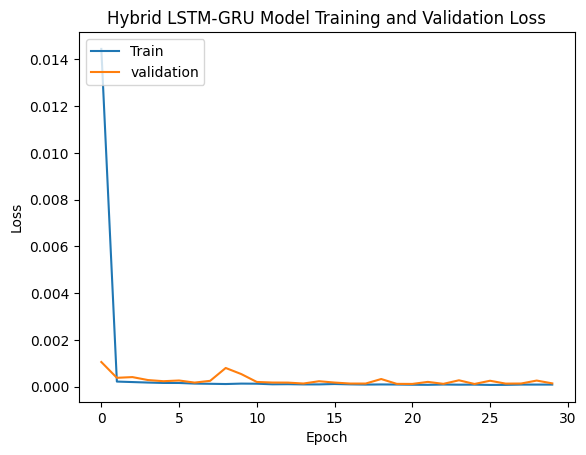

In [26]:
model_hybrid_gru_lstm = Sequential()

model_hybrid_gru_lstm.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=(step_index, 1)))
model_hybrid_gru_lstm.add(GRU(units=64, activation='relu', return_sequences=False))
model_hybrid_gru_lstm.add(Dense(units=1))

model_hybrid_gru_lstm.compile(optimizer='adam', loss='mean_squared_error')

GRU_LSTM_Hybrid_model = model_hybrid_gru_lstm.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1)

plt.plot(GRU_LSTM_Hybrid_model.history['loss'])
plt.plot(GRU_LSTM_Hybrid_model.history['val_loss'])

plt.title('Hybrid LSTM-GRU Model Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.savefig('Hybrid LSTM-GRU Model-Loss.png' )
plt.show()

In [27]:
hybrid_predictions = model_hybrid_gru_lstm.predict(X_Val)

hybrid_predictions_scale_original = scaler.inverse_transform(hybrid_predictions)

y_Val_scale_original = scaler.inverse_transform(y_Val)

16/16 [==============================] - 1s 16ms/step


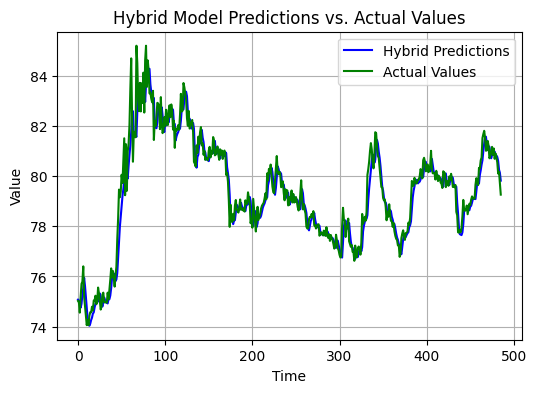

In [28]:
x = range(len(hybrid_predictions_scale_original))

plt.figure(figsize=(6,4))
plt.plot(x, hybrid_predictions_scale_original, label='Hybrid Predictions', color='blue')
plt.plot(x, y_Val_scale_original, label='Actual Values', color='green')

plt.title('Hybrid Model Predictions vs. Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

In [29]:
mape_val = mape_func(y_Val_scale_original, hybrid_predictions_scale_original)

mse_val = mse_func(y_Val_scale_original, hybrid_predictions_scale_original)

rmse_val = rmse_func(y_Val_scale_original, hybrid_predictions_scale_original)

print('Hybrid model performance during validation phase')
print("Hybrid_RMSE:", rmse_val)
print("Hybrid_MSE:", mse_val)
print("Hybrid_MAPE:", mape_val)

Hybrid model performance during validation phase
Hybrid_RMSE: 0.561426763855935
Hybrid_MSE: 0.3152000111737478
Hybrid_MAPE: 0.47837510789487775


**GRU LSTM Model Testing**

In [30]:
hybrid_predictions = model_hybrid_gru_lstm.predict(X_test)

predictions_scale_original = scaler.inverse_transform(hybrid_predictions)

y_test_scale_original = scaler.inverse_transform(y_test)

16/16 [==============================] - 0s 11ms/step


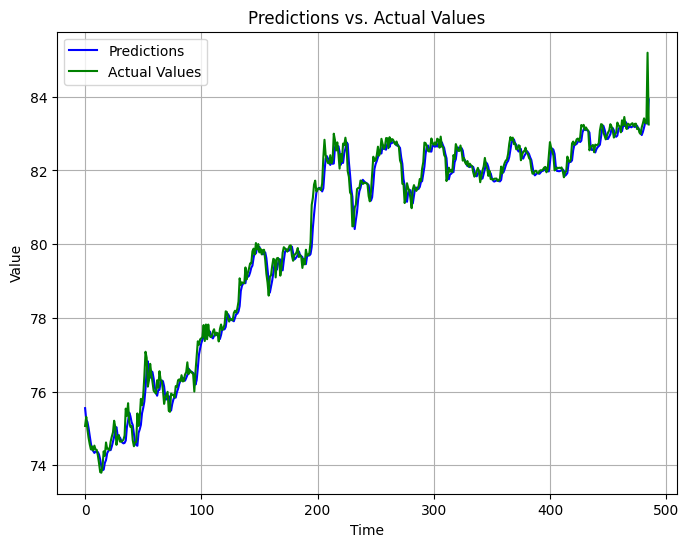

In [31]:
x = range(len(predictions_scale_original))

plt.figure(figsize=(8, 6))
plt.plot(x, predictions_scale_original, label='Predictions', color='blue')
plt.plot(x, y_test_scale_original, label='Actual Values', color='green')

plt.title('Predictions vs. Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

## model performance on validation data

In [32]:
mse_test = mse_func(y_test_scale_original, predictions_scale_original)

rmse_test = rmse_func(y_test_scale_original, predictions_scale_original)

mape_test = mape_func(y_test_scale_original, predictions_scale_original)

print('Hybrid model performance during testing phase')

print("Hybrid MSE:", mse_test)

print("Hybrid RMSE:", rmse_test)

print("Hybrid MAPE:", mape_test)

Hybrid model performance during testing phase
Hybrid MSE: 0.07906870517128534
Hybrid RMSE: 0.2811915809039903
Hybrid MAPE: 0.24443338318451252


**Hybrid GRU Model Prediction**

In [ ]:
num_future_days = 14

lastest_date = pd.to_datetime(data['Date'].iat[-1])

# Generate the list of dates for forecast
next_14_days = [lastest_date + datetime.timedelta(days=i) for i in range(1, num_future_days + 1)]

# Print the predicted rates for the next month
for date, price in zip(next_14_days[:14], predictions_scale_original[-14:]):
    print(f"{date.date()}: {price}")

2023-11-05: [83.104095]
2023-11-06: [83.12559]
2023-11-07: [83.13953]
2023-11-08: [83.05088]
2023-11-09: [83.03413]
2023-11-10: [82.94674]
2023-11-11: [82.8832]
2023-11-12: [82.979866]
2023-11-13: [83.10308]
2023-11-14: [83.24175]
2023-11-15: [83.22622]
2023-11-16: [83.19491]
2023-11-17: [83.96394]
2023-11-18: [83.51764]


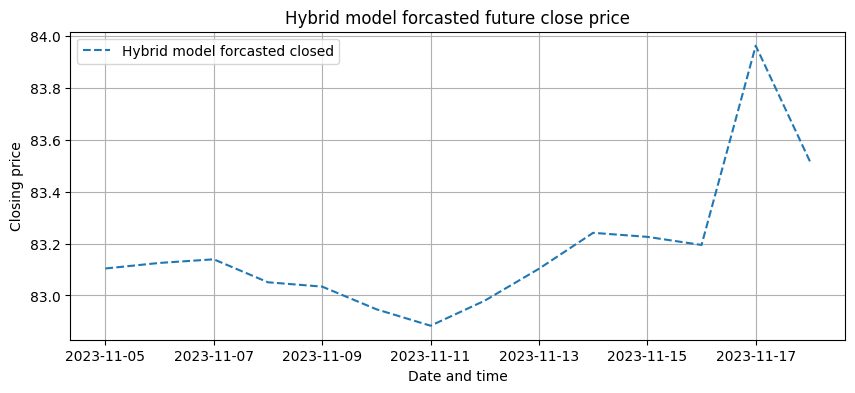

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(next_14_days[:14], predictions_scale_original[-14:], label='Hybrid model forcasted closed', linestyle='dashed')

plt.xlabel('Date and time')
plt.ylabel('Closing price')
plt.title('Hybrid model forcasted future close price')
plt.legend()
plt.grid(True)
plt.savefig('USD to INR hybrid model')
plt.show()

**CNN model**

**Model Fitting**

In [33]:
# Define the CNN model
cnn_model = Sequential()

# Add a 1D convolutional layer with 32 filters, kernel size 3, and ReLU activation
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))

# Add a max pooling layer with pool size 2
cnn_model.add(MaxPooling1D(pool_size=2))

# Flatten the output from the previous layer
cnn_model.add(Flatten())

# Add a fully connected dense layer with 64 units and ReLU activation
cnn_model.add(Dense(64, activation='relu'))

# Add a final dense layer with 1 unit and linear activation for regression
cnn_model.add(Dense(1, activation='linear'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
cnn_model.summary()

#compile the model
cnn_model.compile(optimizer='adam', loss='mean_squared_error')

#train the model
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=16, epochs=20)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 14, 32)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 448)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                28736     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 28929 (113.00 KB)
Trainable params: 28929 (113.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________

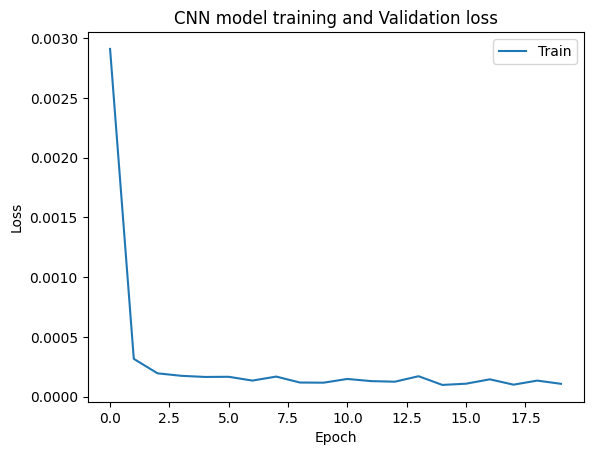

In [34]:
plt.plot(cnn_model_history.history['loss'])

plt.title('CNN model training and Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Train', 'validation'], loc='best')
plt.savefig('CNN_model_loss.png' )
plt.show()

In [36]:
history_test = cnn_model.fit(X_test, y_test, batch_size=16, epochs=30)

Epoch 1/30
31/31 [==============================] - 0s 6ms/step - loss: 5.7014e-04
Epoch 2/30
31/31 [==============================] - 0s 6ms/step - loss: 7.1466e-04
Epoch 3/30
31/31 [==============================] - 0s 5ms/step - loss: 5.2053e-04
Epoch 4/30
31/31 [==============================] - 0s 7ms/step - loss: 5.9896e-04
Epoch 5/30
31/31 [==============================] - 0s 6ms/step - loss: 6.9344e-04
Epoch 6/30
31/31 [==============================] - 0s 6ms/step - loss: 7.7788e-04
Epoch 7/30
31/31 [==============================] - 0s 6ms/step - loss: 5.7932e-04
Epoch 8/30
31/31 [==============================] - 0s 7ms/step - loss: 5.4822e-04
Epoch 9/30
31/31 [==============================] - 0s 7ms/step - loss: 5.7074e-04
Epoch 10/30
31/31 [==============================] - 0s 6ms/step - loss: 6.0870e-04
Epoch 11/30
31/31 [==============================] - 0s 8ms/step - loss: 5.4093e-04
Epoch 12/30
31/31 [==============================] - 0s 6ms/step - loss: 6.6211e-04
E

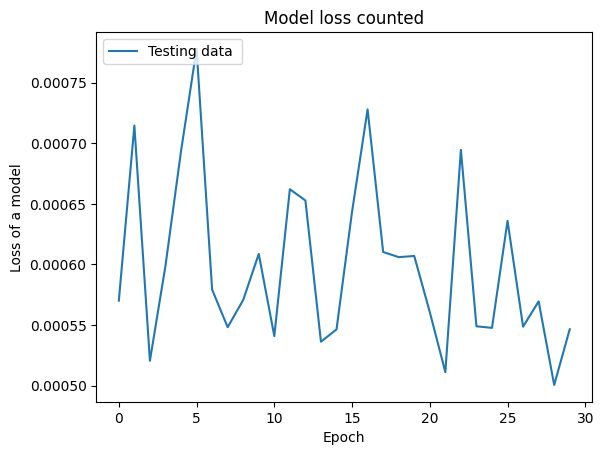

In [37]:
#show model loss
plt.plot(history_test.history['loss'])
plt.title('Model loss counted')
plt.ylabel('Loss of a model')
plt.xlabel('Epoch')
plt.legend(['Testing data '], loc='upper left')
plt.show()

In [38]:
predict = cnn_model.predict(X_test)

predict_original_scale = predict * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]

y_test_original = y_test * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]

16/16 [==============================] - 0s 2ms/step


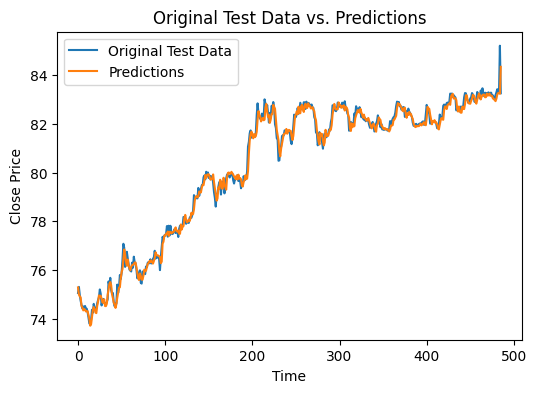

In [39]:
plt.figure(figsize=(6, 4))

# Plot original test data
plt.plot(y_test_original, label='Original Test Data')

# Plot predicted data
plt.plot(predict_original_scale, label='Predictions')

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Original Test Data vs. Predictions')
plt.legend()
plt.savefig('Exchange rate test and actual prediction')
plt.show()

In [40]:
rmse_val = rmse_func(y_test_original, predict_original_scale)
mape_val = mape_func(y_test_original, predict_original_scale)
mse_val = mse_func(y_test_original, predict_original_scale)

print('model performance')
print("RMSE:", rmse_val)
print("MAPE:", mape_val)
print("MSE:", mse_val)

model performance
RMSE: 0.24501077551846398
MAPE: 0.21165260734243804
MSE: 0.060030280120159145


In [41]:
history_val = cnn_model.fit(X_Val, y_Val, batch_size=16, epochs=30)

Epoch 1/30
31/31 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 2/30
31/31 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 3/30
31/31 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 4/30
31/31 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 5/30
31/31 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 6/30
31/31 [==============================] - 0s 7ms/step - loss: 0.0021
Epoch 7/30
31/31 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 8/30
31/31 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 9/30
31/31 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 10/30
31/31 [==============================] - 0s 7ms/step - loss: 0.0024
Epoch 11/30
31/31 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 12/30
31/31 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 13/30
31/31 [==============================

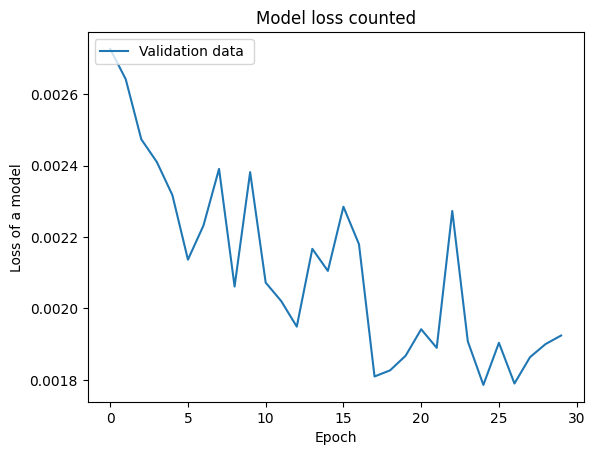

In [42]:
#show model loss
plt.plot(history_val.history['loss'])
plt.title('Model loss counted')
plt.ylabel('Loss of a model')
plt.xlabel('Epoch')
plt.legend(['Validation data '], loc='upper left')
plt.show()

In [43]:
predict_val = cnn_model.predict(X_Val)

predict_original_val = predict_val * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]

y_Val_original = y_Val * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]

16/16 [==============================] - 0s 3ms/step


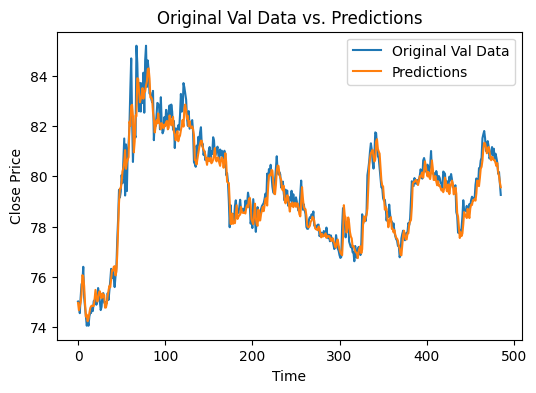

In [44]:
plt.figure(figsize=(6, 4))

# Plot original test data
plt.plot(y_Val_original, label='Original Val Data')

# Plot predicted data
plt.plot(predict_original_val, label='Predictions')

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Original Val Data vs. Predictions')
plt.legend()
plt.savefig('Exchange rate val and actual prediction')
plt.show()

In [45]:
rmse_val = rmse_func(y_Val_original, predict_original_val)
mse_val = mse_func(y_Val_original, predict_original_val)
mape_val = mape_func(y_Val_original, predict_original_val)

print('model performance')
print("RMSE:", rmse_val)
print("MSE:", mse_val)
print("MAPE:", mape_val)

model performance
RMSE: 0.4804696669632516
MSE: 0.2308511008717779
MAPE: 0.43605859611108777


In [ ]:
num_future_days = 14

lastest_date = pd.to_datetime(data['Date'].iat[-1])

# Generate the list of dates for forecast
next_14_days = [lastest_date + datetime.timedelta(days=i) for i in range(1, num_future_days + 1)]

# Print the predicted rates for the next month
for date, price in zip(next_14_days[:14], predict_original_scale[-14:]):
    print(f"{date.date()}: {price}")

2023-11-05: [83.243546]
2023-11-06: [83.23493]
2023-11-07: [83.251366]
2023-11-08: [83.24488]
2023-11-09: [83.19327]
2023-11-10: [83.19757]
2023-11-11: [83.12361]
2023-11-12: [83.18591]
2023-11-13: [83.21994]
2023-11-14: [83.29332]
2023-11-15: [83.31384]
2023-11-16: [83.28494]
2023-11-17: [84.16911]
2023-11-18: [84.07528]


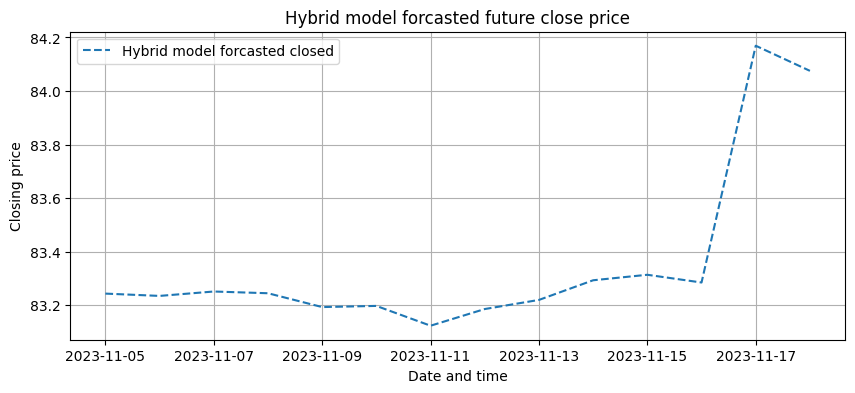

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(next_14_days[:14], predict_original_scale[-14:], label='Hybrid model forcasted closed', linestyle='dashed')

plt.xlabel('Date and time')
plt.ylabel('Closing price')
plt.title('Hybrid model forcasted future close price')
plt.legend()
plt.grid(True)
plt.show()

**ARIMA Model**

**Data Preparatation**

In [46]:
# Define the sizes of training, testing, and validation sets
train_size = int(len(data) * 0.90)  # 90% of the data for training
test_size = int(len(data) * 0.05)   # 5% of the data for testing
val_size = len(data) - train_size - test_size  # Remaining for validation

# Split the data into training, testing, and validation sets
train = data.iloc[:train_size]
validation = data.iloc[train_size: train_size + test_size]
test = data.iloc[train_size + val_size:]

# Print the shapes of the split sets
print(train.shape, test.shape, validation.shape)

(4651, 11) (258, 11) (258, 11)


In [47]:
train_data = train.filter(['Adj Close'])
train_set = train_data.values

test_data = test.filter(['Adj Close'])
test_set = test_data.values

validation_data = validation.filter(['Adj Close'])
validation_set = validation_data.values

train_set.shape,test_set.shape,validation_set.shape

((4651, 1), (258, 1), (258, 1))

<ipython-input-48-78adb4d6c8ac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Date'] = pd.to_datetime(train['Date'])
<ipython-input-48-78adb4d6c8ac>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Date'] = pd.to_datetime(test['Date'])
<ipython-input-48-78adb4d6c8ac>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

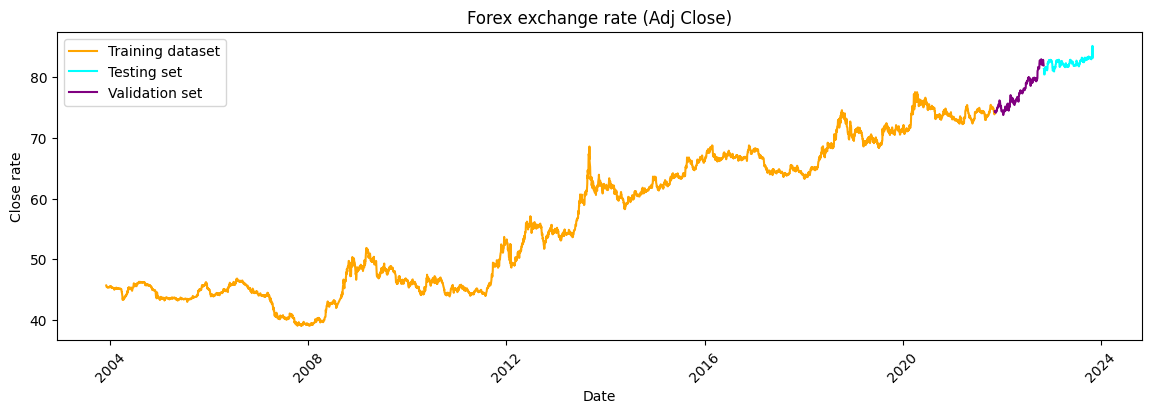

In [48]:
# Assuming you have DataFrames named train, test, and validation with a "Date" column
# Convert the "Date" column to datetime if it's not already
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
validation['Date'] = pd.to_datetime(validation['Date'])

plt.figure(figsize=(14, 4))
plt.plot(train["Date"], train["Adj Close"], color='orange', label='Training dataset')
plt.plot(test["Date"], test["Adj Close"], color='cyan', label='Testing set')
plt.plot(validation["Date"], validation["Adj Close"], color='purple', label='Validation set')

plt.legend()
plt.title('Forex exchange rate (Adj Close)')
plt.xlabel('Date')
plt.ylabel('Close rate')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.savefig('Splitting_of_Data.png')  # Save the plot to a file

plt.show()

**Performing Dickey Fuller Test**

In [49]:
def ad_test_func(dataset):
    dftest = adfuller(dataset, autolag='AIC')
    print("1. ADF: ",dftest[0])
    print("2. P-value:",dftest[1])
    print("3.No of Lags",dftest[2])
    print("4.The number of observations utilised for ADF Calculation of regression and critical values",dftest[3])
    print("5.crtical value:")
    for key, val in dftest[4].items():
        print("\t",key,":",val)

In [50]:
ad_test_func(data["Adj Close"])

1. ADF:  0.19432671172296398
2. P-value: 0.9719415953513485
3.No of Lags 12
4.The number of observations utilised for ADF Calculation of regression and critical values 5155
5.crtical value:
	 1% : -3.4316191676518297
	 5% : -2.862100838573277
	 10% : -2.567068534414715


**Make Stationary data for ARIMA model**

<Axes: >

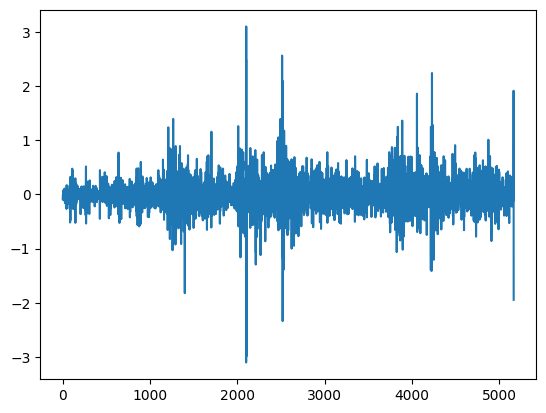

In [51]:
data["Adj Close"].diff(1).dropna().plot()

In [52]:
ad_test_func(data["Adj Close"].diff(1).dropna())

1. ADF:  -20.094217024378278
2. P-value: 0.0
3.No of Lags 11
4.The number of observations utilised for ADF Calculation of regression and critical values 5155
5.crtical value:
	 1% : -3.4316191676518297
	 5% : -2.862100838573277
	 10% : -2.567068534414715


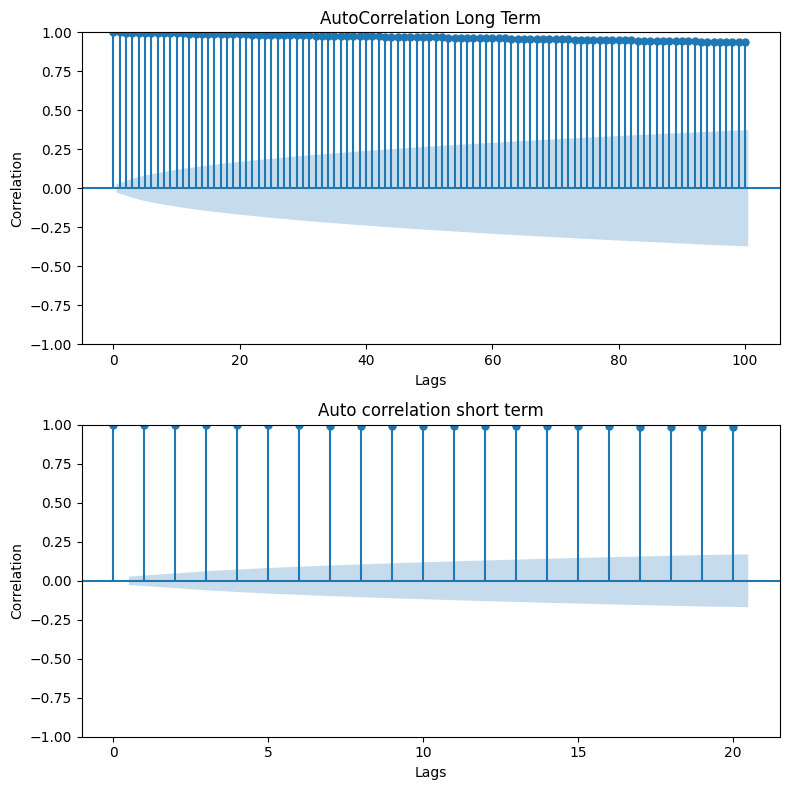

In [53]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))

# Plotting auto-correlation for long term (lags=180)
acf_long_term = plot_acf(data['Adj Close'], lags=100, ax=ax1)
ax1.set_title('AutoCorrelation Long Term')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')

# Plotting auto-correlation for short term (lags=30)
acf_short_term = plot_acf(data['Adj Close'], lags=20, ax=ax2)
ax2.set_title('Auto correlation short term')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')

plt.tight_layout()
plt.savefig('ACF value')

# Displaying the plot
plt.show()

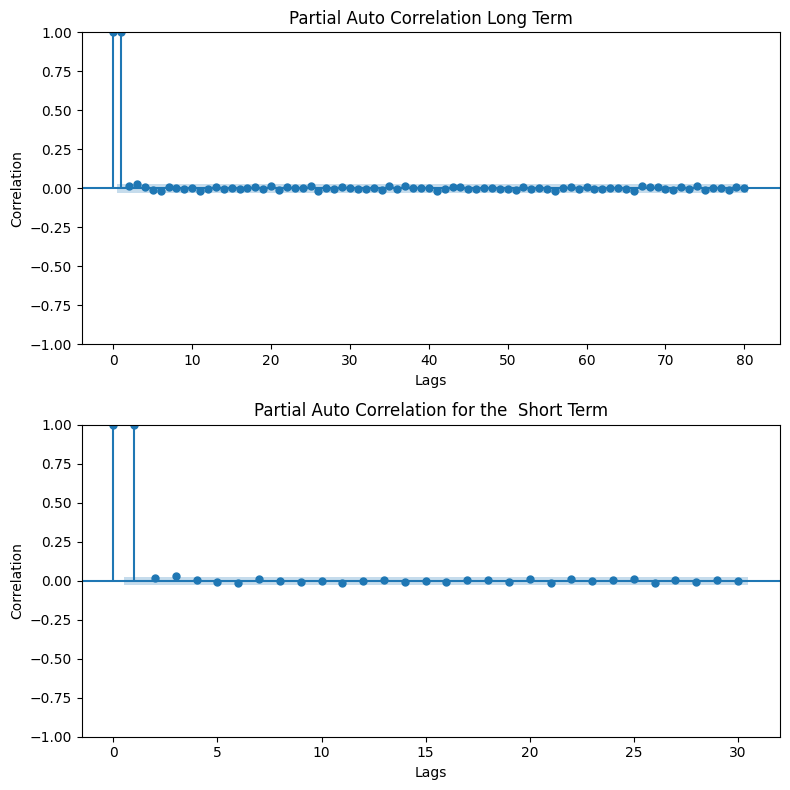

In [54]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8))

# Plotting auto-correlation for long term (lags=80)
plot_pacf(data['Adj Close'], lags=80, ax=ax1)
ax1.set_title('Partial Auto Correlation Long Term')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')

# Plotting auto-correlation for short term (lags=30)
plot_pacf(data['Adj Close'], lags=30, ax=ax2)
ax2.set_title('Partial Auto Correlation for the  Short Term')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')

# Adjust subplot spacing
plt.tight_layout()
plt.savefig('PACF')
# Display the plot
plt.show()

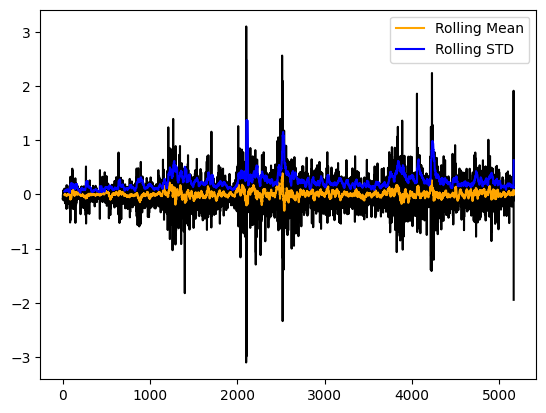

In [55]:
# Differencing
diff_data = data["Adj Close"].diff(1).dropna()

# Plotting the original data
plt.plot(diff_data, c='black')

# Plotting the rolling mean
plt.plot(diff_data.rolling(20).mean(), label='Rolling Mean', c='orange')

# Plotting the rolling standard deviation
plt.plot(diff_data.rolling(20).std(), label='Rolling STD', c='blue')

# Adding legend
plt.legend(prop={'size': 10})

# Displaying the plot
plt.show()

In [56]:
ad_test_func(diff_data)

1. ADF:  -20.094217024378278
2. P-value: 0.0
3.No of Lags 11
4.The number of observations utilised for ADF Calculation of regression and critical values 5155
5.crtical value:
	 1% : -3.4316191676518297
	 5% : -2.862100838573277
	 10% : -2.567068534414715


**ARIMA model after stationary data**

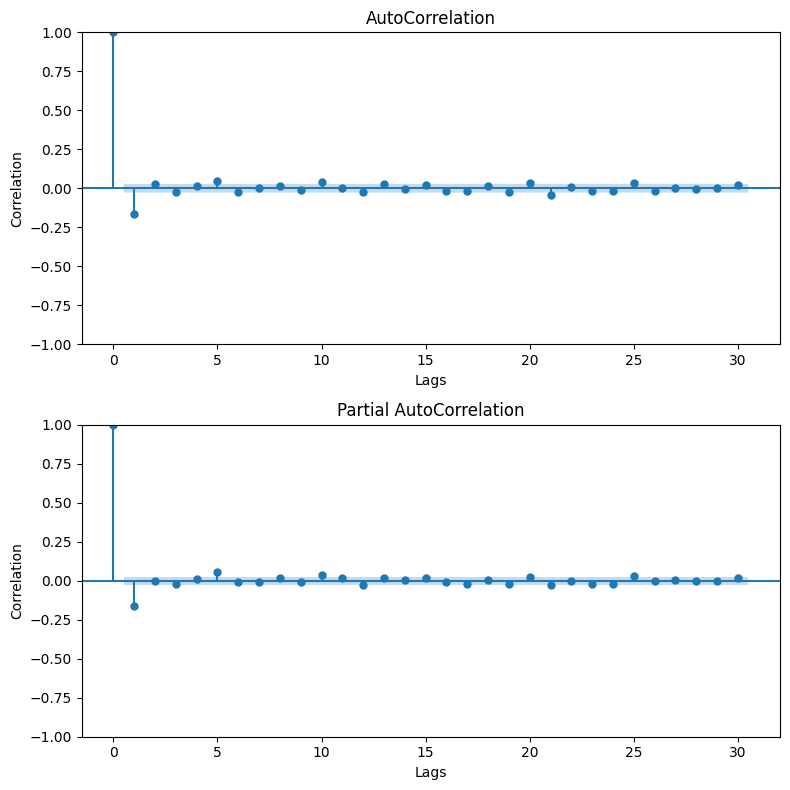

In [57]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8))

# Plotting auto-correlation for long term (lags=180)
plot_acf(diff_data, lags=30, ax=ax1)
ax1.set_title('AutoCorrelation')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')

# Plotting auto-correlation for short term (lags=30)
plot_pacf(diff_data, lags=30, ax=ax2)
ax2.set_title('Partial AutoCorrelation')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')

# Adjust subplot spacing
plt.tight_layout()

# Display the plot
plt.show()


In [58]:
# Define the sizes of training, testing, and validation sets
diff_train_size = int(len(diff_data) * 0.90)  # 80% of the data for training
diff_test_size = int(len(diff_data) * 0.05)   # 10% of the data for testing
diff_val_size = len(diff_data) - diff_train_size - diff_test_size  # Remaining for validation

# Split the data into training, testing, and validation sets
train_diff = data.iloc[:diff_train_size]
validation_diff = data.iloc[diff_train_size: diff_train_size + diff_test_size]
test_diff = data.iloc[diff_train_size + diff_val_size:]

# Print the shapes of the split sets
print(train_diff.shape, test_diff.shape, validation_diff.shape)

(4650, 11) (259, 11) (258, 11)


In [59]:
train_data_diff = train_diff.filter(['Adj Close'])
train_set_diff = train_data_diff.values

test_data_diff = test_diff.filter(['Adj Close'])
test_set_diff = test_data_diff.values

validation_data_diff = validation_diff.filter(['Adj Close'])
validation_set_diff = validation_data_diff.values

train_set_diff.shape,test_set_diff.shape,validation_set_diff.shape

((4650, 1), (259, 1), (258, 1))

In [60]:
warnings.filterwarnings("ignore")
stepwise_fit = auto_arima(train_diff["Adj Close"], trace=True,suppress_warnings=True, seasonal=False)

print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1482.516, Time=8.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1606.589, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1477.341, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1479.952, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1606.659, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1479.330, Time=0.60 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1479.327, Time=0.78 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1481.303, Time=1.48 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1478.250, Time=0.22 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 13.316 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4650
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -735.670
Date:                Thu, 16 Nov 2023   AIC     

In [61]:
orders= (1,1,0)

model = ARIMA(train_diff['Adj Close'],order=orders )
model = model.fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 4650
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -737.125
Date:                Thu, 16 Nov 2023   AIC                           1478.250
Time:                        19:36:16   BIC                           1491.138
Sample:                             0   HQIC                          1482.784
                               - 4650                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1663      0.006    -29.934      0.000      -0.177      -0.155
sigma2         0.0804      0.001    115.265      0.000       0.079       0.082
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [62]:
validation_diff['Date'] = pd.to_datetime(validation_diff['Date'])
validation_diff.set_index('Date', inplace=True)

validation_diff

test_diff['Date'] = pd.to_datetime(test_diff['Date'])
test_diff.set_index('Date', inplace=True)

test_diff

,Open,High,Low,Close,Adj Close,Volume,20MA,Upper,Lower,Daily Return
Date,,,,,,,,,,
2022-11-08,81.825996,82.081802,81.172897,81.825996,81.825996,0,82.432334,83.079828,81.784840,-0.001818
2022-11-09,81.405197,81.669800,81.190300,81.405197,81.405197,0,82.388899,83.181444,81.596353,-0.005143
2022-11-10,81.343803,81.910004,80.727097,81.343803,81.343803,0,82.346089,83.264153,81.428025,-0.000754
2022-11-11,80.482903,80.983002,80.423798,80.482903,80.482903,0,82.260629,83.500763,81.020495,-0.010583
2022-11-14,80.497002,81.287399,80.373100,80.497002,80.497002,0,82.164839,83.630868,80.698810,0.000175
...,...,...,...,...,...,...,...,...,...,...
2023-10-30,83.413399,83.413399,83.223999,83.413399,83.413399,0,83.228520,83.453772,83.003268,0.001572
2023-10-31,83.296501,83.331001,83.224998,83.296501,83.296501,0,83.225375,83.444609,83.006141,-0.001401
2023-11-01,83.277199,83.349297,83.197899,83.277199,83.277199,0,83.227745,83.448202,83.007288,-0.000232


**ARIMA model validation**

In [63]:
# Define the number of forecast steps
num_forecast_steps = len(validation_diff)

# Initialize a list to store the predictions
predictions = []

# Initialize an index for predictions with the same date format
prediction_index = validation_diff.index

# Perform rolling predictions
for i in range(num_forecast_steps):
    # Forecast the next time step
    forecast = model.forecast(steps=1, typ='levels')
    predictions.append(forecast.item())

    # Update the model with the new observed data
    new_observation = validation_diff.iloc[i]['Adj Close']

    # Re-fit the ARIMA model with updated data
    p, d, q = (1, 1, 0)  # Replace with your chosen orders
    model = ARIMA(pd.concat([train_diff['Adj Close'], validation_diff.iloc[:i+1]['Adj Close']]), order=(p, d, q))
    model = model.fit()

# Create a Series with predictions and the original date index
pred_series = pd.Series(predictions, index=prediction_index, name='ARIMA Predictions')

# If you want to compare predictions to actual validation data
predicted_arima = pd.concat([validation_diff['Adj Close'], pred_series], axis=1)

print(predicted_arima)


            Adj Close  ARIMA Predictions
Date                                    
2021-11-10  74.174797          73.963849
2021-11-11  74.404900          74.132125
2021-11-12  74.322098          74.366630
2021-11-15  74.339996          74.335871
2021-11-16  74.435097          74.337019
...               ...                ...
2022-10-31  82.239197          82.379020
2022-11-01  82.728996          82.272070
2022-11-02  82.684502          82.649683
2022-11-03  82.888397          82.691705
2022-11-04  82.681801          82.855385

[258 rows x 2 columns]


In [64]:
rmse_val = rmse_func(predicted_arima['Adj Close'], predicted_arima['ARIMA Predictions'])

mape_val = mape_func(predicted_arima['Adj Close'], predicted_arima['ARIMA Predictions'])

mse_val = mse_func(predicted_arima['Adj Close'], predicted_arima['ARIMA Predictions'])

print("RMSE:", rmse_val)

print("MAPE:", mape_val)

print("MSE:", mse_val)

RMSE: 0.26231772821794597
MAPE: 0.2518306875172713
MSE: 0.06881059053742417


**Arima Model Testing**

In [66]:
model = ARIMA(train_diff['Adj Close'],order= orders)
model = model.fit()

pred = model.forecast(steps=len(validation_diff) ,typ='levels')
pred = pred.rename('ARIMA Predictions')
pred.index = validation_diff.index[:len(pred)]
print(pred.index)

model = pd.concat([train_diff['Adj Close'],validation_diff['Adj Close'],pred])
model

DatetimeIndex(['2021-11-10', '2021-11-11', '2021-11-12', '2021-11-15',
               '2021-11-16', '2021-11-17', '2021-11-18', '2021-11-19',
               '2021-11-22', '2021-11-23',
               ...
               '2022-10-24', '2022-10-25', '2022-10-26', '2022-10-27',
               '2022-10-28', '2022-10-31', '2022-11-01', '2022-11-02',
               '2022-11-03', '2022-11-04'],
              dtype='datetime64[ns]', name='Date', length=258, freq=None)


0                      45.709999
1                      45.629002
2                      45.549999
3                      45.548000
4                      45.449001
                         ...    
2022-10-31 00:00:00    73.957382
2022-11-01 00:00:00    73.957382
2022-11-02 00:00:00    73.957382
2022-11-03 00:00:00    73.957382
2022-11-04 00:00:00    73.957382
Length: 5166, dtype: float64

In [67]:
model = ARIMA(pd.concat([train_diff['Adj Close'],validation_diff['Adj Close']]),order=orders)
model = model.fit()
predictions=[]

for i in range(len(test_diff)):
    # Forecast the next time step
    forecast = model.forecast()
    predictions.append(forecast.item())
    forecast = pd.Series(forecast.item(), index=[test_diff.index[i]])
    #print(forecast)
    model = ARIMA(pd.concat([train_diff['Adj Close'],validation_diff['Adj Close'],forecast]),order=orders)
    model = model.fit()

pred_series = pd.Series(predictions, index=test_diff.index, name='ARIMA Predictions')
predicted_arima = pd.concat([test_diff['Adj Close'], pred_series], axis=1)

print(predicted_arima)

            Adj Close  ARIMA Predictions
Date                                    
2022-11-08  81.825996          82.715269
2022-11-09  81.405197          82.709847
2022-11-10  81.343803          82.705304
2022-11-11  80.482903          82.701497
2022-11-14  80.497002          82.698306
...               ...                ...
2023-10-30  83.413399          82.681801
2023-10-31  83.296501          82.681801
2023-11-01  83.277199          82.681801
2023-11-02  85.194000          82.681801
2023-11-03  83.247299          82.681801

[259 rows x 2 columns]


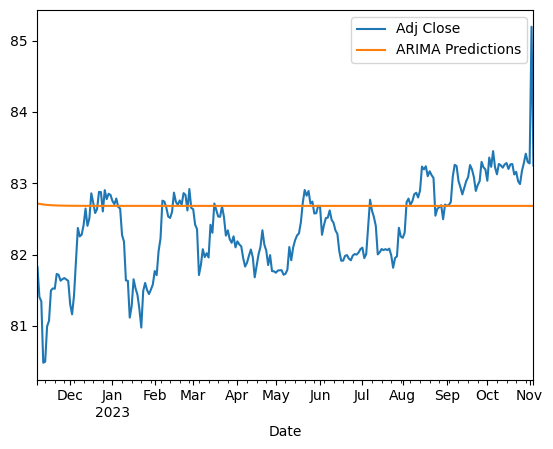

In [68]:
predicted_arima.plot()

plt.savefig('arima prediction')

In [69]:
mape_val = mape_func(predicted_arima['Adj Close'], predicted_arima['ARIMA Predictions'])
mse_val = mse_func(predicted_arima['Adj Close'], predicted_arima['ARIMA Predictions'])
rmse_val = rmse_func(predicted_arima['Adj Close'], predicted_arima['ARIMA Predictions'])

print("MAE:", mape_val)
print("MSE:", mse_val)
print("RMSE:", rmse_val)

MAE: 0.6516784423148873
MSE: 0.4674347741110413
RMSE: 0.6836920170011065


## Future prediction using ARIMA

In [ ]:
# Assuming you have ARIMA Predictions stored in a variable named 'ARIMA_Predictions'
# Make sure to replace 'ARIMA_Predictions' with the actual variable name in your code

num_future_days = 14

# Assuming 'data' is your DataFrame containing historical data with a 'Date' column
lastest_date = pd.to_datetime(data['Date'].iat[-1])

# Generate the list of dates for forecast
next_14_days = [lastest_date + datetime.timedelta(days=i) for i in range(1, num_future_days + 1)]

# Print the predicted rates for the next 14 days
for date, price in zip(next_14_days[:14], predicted_arima['ARIMA Predictions']):
    print(f"{date.date()}: {price}")


2023-11-04: 82.71526896039995
2023-11-05: 82.70984720532144
2023-11-06: 82.70530383971582
2023-11-07: 82.70149653071037
2023-11-08: 82.69830601566554
2023-11-09: 82.69563236091035
2023-11-10: 82.69339182754625
2023-11-11: 82.69151424596805
2023-11-12: 82.68994081637678
2023-11-13: 82.68862226598776
2023-11-14: 82.68751730506798
2023-11-15: 82.68659133328306
2023-11-16: 82.68581535579447
2023-11-17: 82.68516507496561


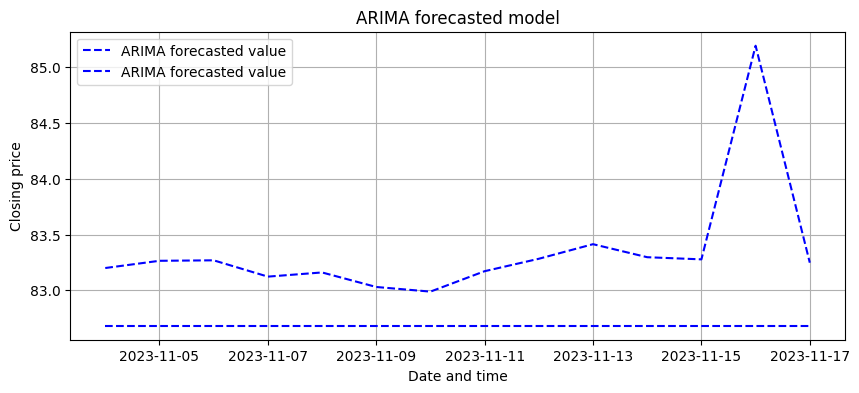

In [ ]:
plt.figure(figsize=(10, 4))

plt.plot(next_14_days[:14], predicted_arima[-14:], label='ARIMA forecasted value', linestyle='dashed', color='blue')
plt.xlabel('Date and time')
plt.ylabel('Closing price')
plt.title('ARIMA forecasted model')

plt.legend()
plt.grid(True)
plt.savefig('forecasting arima model')
plt.show()